In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf 
import random
import gc
import re
import os
import unidecode
from datetime import datetime
from itertools import combinations
from fuzzywuzzy import fuzz
# from tensorflow.python.platform import gfile
# from tensorflow.io import gfile
import tensorflow.compat.v1.gfile as gfile
from sklearn.model_selection import StratifiedKFold
from abydos.phones import *
from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, Covington, PhoneticEditDistance)
from abydos.phonetic import PSHPSoundexFirst, Ainsworth

try:
    import cPickle as pickle
except ImportError:
    import pickle
import collections

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Interim Data File Locations
interim_data = '../data/interim/'

In [4]:
df = pd.read_csv(interim_data + 'feature_engineering_results.csv')
df.shape

(87550, 28)

In [5]:
df.sample(10)

,a,b,target,name_a,name_b,partial,tkn_sort,tkn_set,sum_ipa,pshp_soundex_first,...,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,covington,phoneticeditdistance
41989,Henrietta,Wilhelm,0,henrietta,wilhelm,53,42,42,0.540323,0,...,0.333333,0.000000,0.305556,0.476190,0.109343,0.222222,0.881863,0.293617,0.411392,0.650538
87094,Abel,Mo,0,abel,mo,50,0,0,0.322581,0,...,0.125000,0.000000,0.350000,0.000000,0.000000,0.000000,0.806863,0.300000,0.344828,0.459677
86120,Yannig,Olezha,0,yannig,olezha,52,13,13,0.615591,0,...,0.166667,0.000000,0.116667,0.000000,0.000000,0.166667,0.787745,0.216667,0.421875,0.653226
9270,Lon,Laurence,1,lon,laurence,57,31,31,0.967742,1,...,0.375000,0.000000,0.506250,0.638889,0.000000,0.250000,0.969608,0.312500,0.509804,0.370968
80674,Rafael,Toncio,0,rafael,toncio,57,14,14,0.670507,0,...,0.166667,0.000000,0.100000,0.000000,0.000000,0.000000,0.612255,0.223333,0.515625,0.755376
52317,Varvara,Mareczek,0,varvara,mareczek,63,42,42,0.722581,0,...,0.312500,0.000000,0.325000,0.511905,0.250000,0.250000,0.782353,0.336364,0.553333,0.735887
34605,Helene,Emeline,0,helene,emeline,83,78,78,0.564516,0,...,0.642857,0.296296,0.657143,0.782540,0.571429,0.571429,0.668627,0.651515,0.769231,0.815668
46653,Colt,Quique,0,colt,quique,38,0,0,0.717742,0,...,0.333333,0.000000,0.283333,0.000000,0.000000,0.000000,0.807353,0.115385,0.306122,0.548387
32978,Stana,Tatsuyakun,0,stana,tatsuyakun,69,42,42,0.677419,0,...,0.300000,0.000000,0.345000,0.650000,0.081638,0.300000,0.839216,0.290000,0.464789,0.443548
68038,Nichole,Maxim,0,nichole,maxim,54,27,27,0.691244,0,...,0.214286,0.000000,0.185714,0.447619,0.000000,0.142857,0.894608,0.278378,0.423729,0.603687


In [6]:
# TESTING TESTING TESTING
df = df.sample(100)

In [7]:
random.seed(30)

In [8]:
y = df.target
X = df.drop('target', axis=1)
print("Feature Set: ", X.shape)
print("Label Set: ", y.shape)

Feature Set:  (100, 27)
Label Set:  (100,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print("Training Feature Set: ", X_train.shape)
print("Training Label Set: ", y_train.shape)
print("Testing Feature Set: ", X_test.shape)
print("Testing Label Set: ", y_test.shape)

Training Feature Set:  (80, 27)
Training Label Set:  (80,)
Testing Feature Set:  (20, 27)
Testing Label Set:  (20,)


### Base-Model 1: Exported TPOT Pipeline

In [10]:
def base_model_1(X_train, y_train, X_test, export=False):
    exported_pipeline = make_pipeline(
        MaxAbsScaler(),
        MinMaxScaler(),
        RandomForestClassifier(
            bootstrap=False,
            criterion="gini",
            max_features=0.25,
            min_samples_leaf=1,
            min_samples_split=4,
            n_estimators=100)
    )
    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

### Base-Model 2: Deep LSTM Siamese Network

In [11]:
# tensorflow based implementation of deep siamese LSTM network.
# Taken from https://github.com/dhwajraj/deep-siamese-text-similarity as of 2020-07-20
# and modified to fit hmni prediction pipeline
# deep-siamese-text-similarity original copyright:
#
# MIT License
#
# Copyright (c) 2016 Dhwaj Raj
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import tensorflow as tf


class SiameseLSTM(object):
    """
    A LSTM based deep Siamese network for text similarity.
    Uses an character embedding layer, followed by a biLSTM and Energy Loss layer.
    """

    def BiRNN(self, x, dropout, scope, hidden_units):
        n_hidden = hidden_units
        n_layers = 3

        # Prepare data shape to match `static_rnn` function requirements
        x = tf.unstack(tf.transpose(x, perm=[1, 0, 2]))

        # Define lstm cells with tensorflow
        # Forward direction cell
        with tf.name_scope('fw' + scope):
            with tf.compat.v1.variable_scope('fw' + scope):
                stacked_rnn_fw = []
                for _ in range(n_layers):
                    fw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
                    lstm_fw_cell = \
                        tf.compat.v1.nn.rnn_cell.DropoutWrapper(fw_cell, output_keep_prob=dropout)
                    stacked_rnn_fw.append(lstm_fw_cell)
                lstm_fw_cell_m = \
                    tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_fw, state_is_tuple=True)

        with tf.name_scope('bw' + scope):
            with tf.compat.v1.variable_scope('bw' + scope):
                stacked_rnn_bw = []
                for _ in range(n_layers):
                    bw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
                    lstm_bw_cell = \
                        tf.compat.v1.nn.rnn_cell.DropoutWrapper(bw_cell, output_keep_prob=dropout)
                    stacked_rnn_bw.append(lstm_bw_cell)
                lstm_bw_cell_m = \
                    tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_bw, state_is_tuple=True)

        # Get lstm cell output
        with tf.name_scope('bw' + scope):
            with tf.compat.v1.variable_scope('bw' + scope):
                (outputs, _, _) = \
                    tf.compat.v1.nn.static_bidirectional_rnn(lstm_fw_cell_m,
                                                   lstm_bw_cell_m, x, dtype=tf.float32)
        return outputs[-1]

    def contrastive_loss(self, y, d, batch_size):
        tmp = y * tf.square(d)
        tmp2 = (1 - y) * tf.square(tf.maximum(1 - d, 0))
        return tf.reduce_sum(tmp + tmp2) / batch_size / 2

    def __init__(self, sequence_length, vocab_size, embedding_size, hidden_units, batch_size):

        # Placeholders for input, output and dropout
        self.input_x1 = tf.compat.v1.placeholder(tf.int32, [None, sequence_length], name='input_x1')
        self.input_x2 = tf.compat.v1.placeholder(tf.int32, [None, sequence_length], name='input_x2')
        self.input_y = tf.compat.v1.placeholder(tf.float32, [None], name='input_y')
        self.dropout_keep_prob = tf.compat.v1.placeholder(tf.float32, name='dropout_keep_prob')

        # Embedding layer
        with tf.name_scope('embedding'):
            self.W = tf.Variable(tf.compat.v1.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                                 trainable=True, name='W')
            self.embedded_chars1 = tf.nn.embedding_lookup(self.W, self.input_x1)

            self.embedded_chars2 = tf.nn.embedding_lookup(self.W, self.input_x2)

        # Create a convolution + maxpool layer for each filter size
        with tf.name_scope('output'):
            self.out1 = self.BiRNN(
                self.embedded_chars1,
                self.dropout_keep_prob,
                'side1',
                hidden_units
            )
            self.out2 = self.BiRNN(
                self.embedded_chars2,
                self.dropout_keep_prob,
                'side2',
                hidden_units
            )
            self.distance = \
                tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.out1, self.out2)), 1, keepdims=True))
            self.distance = tf.compat.v1.div(self.distance,
                                   tf.add(tf.sqrt(tf.reduce_sum(tf.square(self.out1), 1, keepdims=True)),
                                          tf.sqrt(tf.reduce_sum(tf.square(self.out2), 1, keepdims=True))))
            self.distance = tf.reshape(self.distance, [-1], name='distance')
        with tf.name_scope('loss'):
            self.loss = self.contrastive_loss(self.input_y, self.distance, batch_size)

        # Accuracy computation is outside of this class.
        with tf.name_scope('accuracy'):
            self.temp_sim = tf.subtract(tf.ones_like(self.distance),
                                        tf.compat.v1.rint(self.distance), name='temp_sim')  # auto threshold 0.5
            correct_predictions = tf.equal(self.temp_sim, self.input_y)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')


In [12]:
# tensorflow based implementation of deep siamese LSTM network.
# Taken from https://github.com/dhwajraj/deep-siamese-text-similarity as of 2020-07-20
# and modified to fit hmni prediction pipeline
# deep-siamese-text-similarity original copyright:
#
# MIT License
#
# Copyright (c) 2016 Dhwaj Raj
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

TOKENIZER_RE = re.compile(r"[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+", re.UNICODE)


def tokenizer(iterator):
    """Tokenizer generator.
    Args:
      iterator: Input iterator with strings.
    Yields:
      array of tokens per each value in the input.
    """
    for value in iterator:
        yield TOKENIZER_RE.findall(value)


class CategoricalVocabulary(object):
    """Categorical variables vocabulary class.
  Accumulates and provides mapping from classes to indexes.
  Can be easily used for words.
  """
    def __init__(self, unknown_token="<UNK>", support_reverse=True):
        self._unknown_token = unknown_token
        self._mapping = {unknown_token: 0}
        self._support_reverse = support_reverse
        if support_reverse:
            self._reverse_mapping = [unknown_token]
        self._freq = collections.defaultdict(int)
        self._freeze = False

    def __len__(self):
        """Returns total count of mappings. Including unknown token."""
        return len(self._mapping)

    def freeze(self, freeze=True):
        """Freezes the vocabulary, after which new words return unknown token id.
        Args:
          freeze: True to freeze, False to unfreeze.
        """
        self._freeze = freeze

    def get(self, category):
        """Returns word's id in the vocabulary.
        If category is new, creates a new id for it.
        Args:
          category: string or integer to lookup in vocabulary.
        Returns:
          interger, id in the vocabulary.
        """
        if category not in self._mapping:
            if self._freeze:
                return 0
            self._mapping[category] = len(self._mapping)
            if self._support_reverse:
                self._reverse_mapping.append(category)
        return self._mapping[category]

    def add(self, category, count=1):
        """Adds count of the category to the frequency table.
        Args:
          category: string or integer, category to add frequency to.
          count: optional integer, how many to add.
        """
        category_id = self.get(category)
        if category_id <= 0:
            return
        self._freq[category] += count

    def trim(self, min_frequency, max_frequency=-1):
        """Trims vocabulary for minimum frequency.
        Remaps ids from 1..n in sort frequency order.
        where n - number of elements left.
        Args:
          min_frequency: minimum frequency to keep.
          max_frequency: optional, maximum frequency to keep.
            Useful to remove very frequent categories (like stop words).
        """
        # Sort by alphabet then reversed frequency.
        self._freq = sorted(
            sorted(
                self._freq.items(),
                key=lambda x: (isinstance(x[0], str), x[0])),
            key=lambda x: x[1],
            reverse=True)
        self._mapping = {self._unknown_token: 0}
        if self._support_reverse:
            self._reverse_mapping = [self._unknown_token]
        idx = 1
        for category, count in self._freq:
            if 0 < max_frequency <= count:
                continue
            if count <= min_frequency:
                break
            self._mapping[category] = idx
            idx += 1
            if self._support_reverse:
                self._reverse_mapping.append(category)
        self._freq = dict(self._freq[:idx - 1])

    def reverse(self, class_id):
        """Given class id reverse to original class name.
        Args:
          class_id: Id of the class.
        Returns:
          Class name.
        Raises:
          ValueError: if this vocabulary wasn't initialized with support_reverse.
        """
        if not self._support_reverse:
            raise ValueError("This vocabulary wasn't initialized with "
                             "support_reverse to support reverse() function.")
        return self._reverse_mapping[class_id]


class VocabularyProcessor(object):
    """Maps documents to sequences of word ids."""

    def __init__(self,
                 max_document_length,
                 min_frequency=0,
                 vocabulary=None,
                 tokenizer_fn=None):
        """Initializes a VocabularyProcessor instance.
        Args:
          max_document_length: Maximum length of documents.
            if documents are longer, they will be trimmed, if shorter - padded.
          min_frequency: Minimum frequency of words in the vocabulary.
          vocabulary: CategoricalVocabulary object.
        Attributes:
          vocabulary_: CategoricalVocabulary object.
        """
        self.max_document_length = max_document_length
        self.min_frequency = min_frequency
        if vocabulary:
            self.vocabulary_ = vocabulary
        else:
            self.vocabulary_ = CategoricalVocabulary()
        if tokenizer_fn:
            self._tokenizer = tokenizer_fn
        else:
            self._tokenizer = tokenizer

    def fit(self, raw_documents):
        """Learn a vocabulary dictionary of all tokens in the raw documents.
        Args:
          raw_documents: An iterable which yield either str or unicode.
        Returns:
          self
        """
        for tokens in self._tokenizer(raw_documents):
            for token in tokens:
                self.vocabulary_.add(token)
        if self.min_frequency > 0:
            self.vocabulary_.trim(self.min_frequency)
        self.vocabulary_.freeze()
        return self

    def fit_transform(self, raw_documents):
        """Learn the vocabulary dictionary and return indexies of words.
        Args:
          raw_documents: An iterable which yield either str or unicode.
        Returns:
          x: iterable, [n_samples, max_document_length]. Word-id matrix.
        """
        self.fit(raw_documents)
        return self.transform(raw_documents)

    def transform(self, raw_documents):
        """Transform documents to word-id matrix.
        Convert words to ids with vocabulary fitted with fit or the one
        provided in the constructor.
        Args:
          raw_documents: An iterable which yield either str or unicode.
        Yields:
          x: iterable, [n_samples, max_document_length]. Word-id matrix.
        """
        for tokens in self._tokenizer(raw_documents):
            word_ids = np.zeros(self.max_document_length, np.int64)
            for idx, token in enumerate(tokens):
                if idx >= self.max_document_length:
                    break
                word_ids[idx] = self.vocabulary_.get(token)
            yield word_ids

    def save(self, filename):
        """Saves vocabulary processor into given file.
        Args:
          filename: Path to output file.
        """
        with gfile.Open(filename, 'wb') as f:
            f.write(pickle.dumps(self))

    @classmethod
    def restore(cls, filename):
        """Restores vocabulary processor from given file.
        Args:
          filename: Path to file to load from.
        Returns:
          VocabularyProcessor object.
        """
        with gfile.Open(filename, 'rb') as f:
            return pickle.loads(f.read())


def tokenizer_char(iterator):
    for value in iterator:
        yield list(value)


class MyVocabularyProcessor(VocabularyProcessor):
    def __init__(self, max_document_length, min_frequency=0, vocabulary=None):
        super().__init__(max_document_length, min_frequency, vocabulary)
        sup = super(MyVocabularyProcessor, self)
        sup.__init__(max_document_length, min_frequency, vocabulary,
                     tokenizer_char)

    def transform(self, raw_documents):
        """Transform documents to word-id matrix.
        Convert words to ids with vocabulary fitted with fit or the one
        provided in the constructor.
        Args:
          raw_documents: An iterable which yield either str or unicode.
        Yields:
          x: iterable, [n_samples, max_document_length]. Word-id matrix.
        """
        for tokens in self._tokenizer(raw_documents):
            word_ids = np.zeros(self.max_document_length, np.int64)
            for (idx, token) in enumerate(tokens):
                if idx >= self.max_document_length:
                    break
                word_ids[idx] = self.vocabulary_.get(token)
            yield word_ids


In [13]:
def base_model_2(X_train, y_train, X_test, export=False):
    
    # Train Model
    embedding_dim = 300  # Dimensionality of character embedding
    dropout_keep_prob = 0.8  # Dropout keep probability
    hidden_units = 50
    batch_size = 64
    num_epochs = 300  # Number of training epochs
    evaluate_every = 1000  # Evaluate model on dev set after this many steps
    max_document_length = 15
    out_dir = os.getcwd()+'\\'  # where to save exported models

    inpH = InputHelper()
    train_set, dev_set, vocab_processor, sum_no_of_batches = \
        inpH.get_datasets(
        X_train[['name_a', 'name_b']],
        y_train,
        max_document_length=max_document_length,
        percent_dev=10,
        batch_size=64)


    # print('starting graph def')
    graph = tf.Graph()
    with tf.Graph().as_default():
        session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        sess = tf.compat.v1.Session(config=session_conf)
        # print('started session')
        with sess.as_default():
            siameseModel = SiameseLSTM(
                sequence_length=max_document_length,
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                hidden_units=hidden_units,
                batch_size=batch_size,
            )

            # Define Training procedure
            global_step = tf.Variable(0, name='global_step', trainable=False)
            # optimizer = tf.optimizers.Adam(1e-3)
            # optimizer = Adam(1e-3)
            optimizer = tf.compat.v1.train.AdamOptimizer(1e-3)
            # print('initialized siameseModel object')

        grads_and_vars = optimizer.compute_gradients(siameseModel.loss)
        tr_op_set = optimizer.apply_gradients(grads_and_vars, global_step=global_step)
        # print('defined training_ops')
        
        if export==True:
            saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables(), max_to_keep=100)
            # Write vocabulary
            vocab_processor.save(os.path.join(out_dir, 'vocab'))

        # Initialize all variables
        sess.run(tf.compat.v1.global_variables_initializer())

        def train_step(x1_batch, x2_batch, y_batch):
            # A single training step
            if random.random() > 0.5:
                feed_dict = {
                    siameseModel.input_x1: x1_batch,
                    siameseModel.input_x2: x2_batch,
                    siameseModel.input_y: y_batch,
                    siameseModel.dropout_keep_prob: dropout_keep_prob,
                }
            else:
                feed_dict = {
                    siameseModel.input_x1: x2_batch,
                    siameseModel.input_x2: x1_batch,
                    siameseModel.input_y: y_batch,
                    siameseModel.dropout_keep_prob: dropout_keep_prob,
                }
            (_, step, loss, accuracy, dist, sim) = \
                sess.run([tr_op_set, global_step, siameseModel.loss, siameseModel.accuracy,
                          siameseModel.distance, siameseModel.temp_sim], feed_dict)

        def dev_step(x1_batch, x2_batch, y_batch):
            # A single training step
            if random.random() > 0.5:
                feed_dict = {
                    siameseModel.input_x1: x1_batch,
                    siameseModel.input_x2: x2_batch,
                    siameseModel.input_y: y_batch,
                    siameseModel.dropout_keep_prob: 1.0,
                }
            else:
                feed_dict = {
                    siameseModel.input_x1: x2_batch,
                    siameseModel.input_x2: x1_batch,
                    siameseModel.input_y: y_batch,
                    siameseModel.dropout_keep_prob: 1.0,
                }
            (step, loss, accuracy, sim) = \
                sess.run([global_step, siameseModel.loss, siameseModel.accuracy,
                          siameseModel.temp_sim], feed_dict)
            return accuracy

        # Generate batches
        batches = inpH.batch_iter(list(zip(train_set[0], train_set[1],
                                           train_set[2])), batch_size, num_epochs)
        max_validation_acc = 0.0
        for nn in range(sum_no_of_batches * num_epochs):
            batch = next(batches)
            if len(batch) < 1:
                continue
            (x1_batch, x2_batch, y_batch) = zip(*batch)
            if len(y_batch) < 1:
                continue
            train_step(x1_batch, x2_batch, y_batch)
            current_step = tf.compat.v1.train.global_step(sess, global_step)
            sum_acc = 0.0
            if current_step % evaluate_every == 0:
                dev_batches = inpH.batch_iter(list(zip(dev_set[0], dev_set[1], dev_set[2])), batch_size, 1)
                for db in dev_batches:
                    if len(db) < 1:
                        continue
                    (x1_dev_b, x2_dev_b, y_dev_b) = zip(*db)
                    if len(y_dev_b) < 1:
                        continue
                    acc = dev_step(x1_dev_b, x2_dev_b, y_dev_b)
                    sum_acc = sum_acc + acc
            if sum_acc > max_validation_acc:
                max_validation_acc = sum_acc
            
                if export==True:
                    # save model
                    saver.save(sess, out_dir, global_step=current_step)
                    tf.train.write_graph(sess.graph.as_graph_def(), out_dir, 'siamese_network.pb', as_text=False)
                
                # print('model {} with sum_accuracy={}'.format(nn, max_validation_acc))     
        if export==True:
            return
        
        # RUN OOF INFERENCE
        x1_temp= np.asarray(X_test['name_a'].tolist())
        x2_temp= np.asarray(X_test['name_b'].tolist())
        
        x1 = np.asarray(list(vocab_processor.transform(x1_temp)))
        x2 = np.asarray(list(vocab_processor.transform(x2_temp)))

        (predictions, sim) = sess.run([siameseModel.distance, siameseModel.temp_sim], {
                siameseModel.input_x1: x1,
                siameseModel.input_x2: x2,
                siameseModel.dropout_keep_prob: 1.0,
            })
                
        sim = predictions.tolist()
        sim = [1-x for x in sim]
        # print(sim)
        return sim

In [14]:
# tensorflow based implementation of deep siamese LSTM network.
# Taken from https://github.com/dhwajraj/deep-siamese-text-similarity as of 2020-07-20
# and modified to fit hmni prediction pipeline
# deep-siamese-text-similarity original copyright:
#
# MIT License
#
# Copyright (c) 2016 Dhwaj Raj
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class InputHelper(object):
    vocab_processor = None

    def batch_iter(
            self,
            data,
            batch_size,
            num_epochs,
            shuffle=True,
    ):

        # Generates a batch iterator for a dataset.
        data = np.asarray(data)
        data_size = len(data)
        num_batches_per_epoch = int(len(data) / batch_size) + 1
        for epoch in range(num_epochs):

            # Shuffle the data at each epoch
            if shuffle:
                shuffle_indices = \
                    np.random.permutation(np.arange(data_size))
                shuffled_data = data[shuffle_indices]
            else:
                shuffled_data = data
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                yield shuffled_data[start_index:end_index]

    # Data Preparation
    def get_datasets(
            self,
            X_train,
            y_train,
            max_document_length,
            percent_dev,
            batch_size,
    ):
        (x1_text, x2_text, y) = \
            np.asarray(X_train.iloc[:, 0].str.lower()), np.asarray(X_train.iloc[:, 1].str.lower()), np.asarray(y_train)

        # Build vocabulary
        # print('Building vocabulary')
        vocab_processor = MyVocabularyProcessor(max_document_length, min_frequency=0)
        vocab_processor.fit_transform(np.concatenate((x2_text, x1_text), axis=0))
        # print('Length of loaded vocabulary ={}'.format(len(vocab_processor.vocabulary_)))

        sum_no_of_batches = 0
        x1 = np.asarray(list(vocab_processor.transform(x1_text)))
        x2 = np.asarray(list(vocab_processor.transform(x2_text)))

        # Randomly shuffle data
        np.random.seed(131)
        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x1_shuffled = x1[shuffle_indices]
        x2_shuffled = x2[shuffle_indices]
        y_shuffled = y[shuffle_indices]
        dev_idx = -1 * len(y_shuffled) * percent_dev // 100
        del x1
        del x2

        # TODO: This is very crude, should use cross-validation
        (x1_train, x1_dev) = (x1_shuffled[:dev_idx], x1_shuffled[dev_idx:])
        (x2_train, x2_dev) = (x2_shuffled[:dev_idx], x2_shuffled[dev_idx:])
        (y_train, y_dev) = (y_shuffled[:dev_idx], y_shuffled[dev_idx:])
        # print('Train/Dev split for data: {:d}/{:d}'.format(len(y_train), len(y_dev)))

        sum_no_of_batches = sum_no_of_batches + len(y_train) // batch_size
        train_set = (x1_train, x2_train, y_train)
        dev_set = (x1_dev, x2_dev, y_dev)
        gc.collect()
        return train_set, dev_set, vocab_processor, sum_no_of_batches

    def getTestDataSet(
            self,
            X_test,
            y_test,
            vocab,
            max_document_length,
    ):
        (x1_temp, x2_temp, y) = np.asarray(X_test.iloc[:, 0].str.lower()), np.asarray(
            X_test.iloc[:, 1].str.lower()), np.asarray(y_test)

        # Build vocabulary
        vocab_processor = MyVocabularyProcessor(max_document_length, min_frequency=0)
        vocab_processor = vocab

        x1 = np.asarray(list(vocab_processor.transform(x1_temp)))
        x2 = np.asarray(list(vocab_processor.transform(x2_temp)))

        # Randomly shuffle data
        del vocab_processor
        gc.collect()
        return x1, x2, y


In [15]:
# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['name_a', 'name_b']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'name_a', 'name_b'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'name_a', 'name_b'], 1))

    oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
                                      y_train,
                                      X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fol

In [16]:
meta_training.sample(10)

,name_a,name_b,predict_proba,siamese_sim,target
10555,mary,marylou,0.950000,0.065085,1
57876,lode,mikey,0.046667,0.188817,0
60631,trent,radisa,0.028333,0.004510,0
64563,oleta,dareczek,0.000000,0.011909,0
68720,lora,karol,0.063333,0.026410,0
85305,anabelle,sigismand,0.025000,0.706787,0
13764,randolph,rand,0.990000,0.005344,1
4159,eliza,besse,0.000000,0.248512,1
78932,sigmund,gerie,0.000000,0.142358,0
3166,danny,danielle,0.910000,0.969730,1


## Meta-Model: Logistic Regression

In [17]:

def syllables(word):
    # single syllable word
    if len(re.findall('[aeiouy]', word)) <= 1:
        return [word]

    # sonority hierarchy: vowels, nasals, fricatives, stops
    hierarchy = {
        'a': 4, 'e': 4, 'i': 4, 'o': 4, 'u': 4, 'y': 4,
        'l': 3, 'm': 3, 'n': 3, 'r': 3, 'w': 3,
        'f': 2, 's': 2, 'v': 2, 'z': 2,
        'b': 1, 'c': 1, 'd': 1, 'g': 1, 'h': 1, 'j': 1, 'k': 1, 'p': 1, 'q': 1, 't': 1, 'x': 1,
    }
    syllables_values = [(c, hierarchy[c]) for c in word]

    syllables = []
    syll = syllables_values[0][0]
    for trigram in zip(*[syllables_values[i:] for i in range(3)]):
        (phonemes, values) = zip(*trigram)
        (previous, val, following) = values
        phoneme = phonemes[1]

        if previous > val < following:
            syllables.append(syll)
            syll = phoneme
        elif previous >= val == following:
            syll += phoneme
            syllables.append(syll)
            syll = ''
        else:
            syll += phoneme
    syll += syllables_values[-1][0]
    syllables.append(syll)

    final_syllables = []
    front = ''
    for (i, syllable) in enumerate(syllables):
        if not re.search('[aeiouy]', syllable):
            if len(final_syllables) == 0:
                front += syllable
            else:
                final_syllables = final_syllables[:-1] \
                                  + [final_syllables[-1] + syllable]
        else:
            if len(final_syllables) == 0:
                final_syllables.append(front + syllable)
            else:
                final_syllables.append(syllable)
    return final_syllables

In [18]:
def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['name_a'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower().strip()), axis=1)
    df['name_b'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower().strip()), axis=1)
    
    df['syll_a'] = df.apply(lambda row: syllables(row.name_a), axis=1)
    df['syll_b'] = df.apply(lambda row: syllables(row.name_b), axis=1)
    
    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.syll_a,row.syll_b), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.syll_a,row.syll_b), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.syll_a,row.syll_b), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.name_a, row.name_b), axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.name_a)==pshp_soundex_first.encode(row.name_b) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.apply(lambda row: algo.sim(row.name_a, row.name_b), axis=1)
            
    df.drop(['syll_a', 'syll_b'], axis=1, inplace=True)
    return df

In [19]:
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [20]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
covington = Covington()
phonetic_edit = PhoneticEditDistance()

In [21]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, covington, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline', 'covington',
              'phoneticeditdistance']

In [22]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [23]:
df = featurize(meta_training)

In [24]:
df.head()

,a,b,predict_proba,siamese_sim,target,name_a,name_b,partial,tkn_sort,tkn_set,...,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,covington,phoneticeditdistance
41317,acho,cenia,0.025000,0.933845,0,acho,cenia,67,36,36,...,0.200000,0.000000,0.160000,0.483333,0.133333,0.200000,0.867157,0.304348,0.466667,0.593548
13062,pat,patte,0.855000,0.356006,1,pat,patte,86,67,100,...,0.800000,0.266667,0.900000,0.866667,0.550000,0.600000,0.994118,0.703704,0.756410,0.600000
53784,ilj,hose,0.000000,0.002509,0,ilj,hose,43,0,0,...,0.125000,0.000000,0.175000,0.000000,0.000000,0.000000,0.618627,0.200000,0.314286,0.604839
62193,vilmoska,sebastjan,0.030000,0.043697,0,vilmoska,sebastjan,65,29,29,...,0.222222,0.000000,0.272222,0.490741,0.188889,0.222222,0.696078,0.425490,0.535294,0.702509
40015,zeland,liz,0.006667,0.049105,0,zeland,liz,57,40,40,...,0.250000,0.000000,0.366667,0.500000,0.050000,0.166667,0.799510,0.308824,0.465116,0.467742


## Grid Search

In [25]:
cols = [col for col in df.columns if col not in ['a', 'b', 'name_a', 'name_b', 'target', 'predict_proba', 'siamese_sim']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [27]:
clf = LogisticRegression(solver='liblinear')
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba', 'siamese_sim']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba', 'siamese_sim']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [28]:
scores_df = pd.DataFrame(scores)

In [29]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [30]:
scores_df.head()

,features,tn,fp,fn,tp
0,"('partial',)",16,0,3,1
1,"('tkn_sort',)",16,0,3,1
2,"('tkn_set',)",16,0,4,0
3,"('sum_ipa',)",16,0,3,1
4,"('pshp_soundex_first',)",16,0,3,1


In [31]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [32]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=1)

In [34]:
selected_cols = ['predict_proba', 'siamese_sim', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [35]:
clf = LogisticRegression(solver='liblinear')
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [36]:
print(grid_clf.best_params_)

{'C': 0.615848211066026}


## Evaluation

In [37]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [38]:
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.75      1.00      0.86         3

    accuracy                           0.95        20
   macro avg       0.88      0.97      0.91        20
weighted avg       0.96      0.95      0.95        20

           Predicted: 0  Predicted: 1
Actual: 0            16             1
Actual: 1             0             3


Text(0.6, 0.3, 'AUC=0.941')

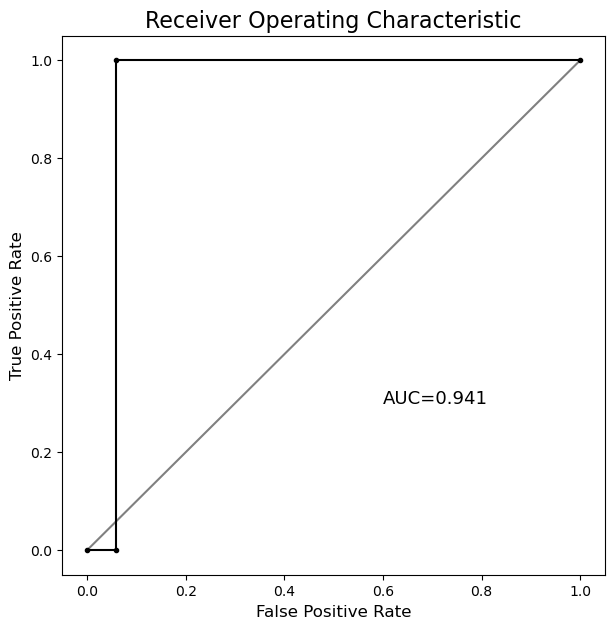

In [39]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

## Export Models and Pipeline

In [40]:
import joblib
import json

In [41]:
base_1 = base_model_1(X.drop(['a', 'b', 'name_a', 'name_b'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='base.pkl')

['base.pkl']

In [42]:
base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [43]:
joblib.dump(grid_clf.best_estimator_, filename='meta.pkl')

['meta.pkl']